In [1]:
# imports and utils

import tensorflow.compat.v2 as tf
import ddsp.training
_AUTOTUNE = tf.data.experimental.AUTOTUNE
from IPython.display import Audio, display
from livelossplot import PlotLosses
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
import data

# define constants
N_SAMPLES=16000*4
SAMPLE_RATE=16000
SEED=1

tf.random.set_seed(
    SEED
)
np.random.seed(SEED)
random.seed(SEED)



# define some utilis
def play(audio):
  display(Audio(audio,rate=SAMPLE_RATE))


In [2]:
    
USE_NSYNTH=False
if USE_NSYNTH:
    
    class CustomNSynthTfds(ddsp.training.data.TfdsProvider):
      """Parses features in the TFDS NSynth dataset.
      Unlike the default Nsynth data provider, this class keeps the the nsynth instrument metadata.

      If running on Cloud, it is recommended you set `data_dir` to
      'gs://tfds-data/datasets' to avoid unnecessary downloads.
      """

      def __init__(self,
                   name='nsynth/gansynth_subset.f0_and_loudness:2.3.3',
                   split='train',
                   data_dir='gs://tfds-data/datasets',
                   sample_rate=16000,
                   frame_rate=250,
                   include_note_labels=True):
        """TfdsProvider constructor.
        Args:
          name: TFDS dataset name (with optional config and version).
          split: Dataset split to use of the TFDS dataset.
          data_dir: The directory to read the prepared NSynth dataset from. Defaults
            to the public TFDS GCS bucket.
          sample_rate: Sample rate of audio in the dataset.
          frame_rate: Frame rate of features in the dataset.
          include_note_labels: Return dataset without note-level labels
            (pitch, instrument).
        """
        self._include_note_labels = include_note_labels

        super().__init__(name, split, data_dir, sample_rate, frame_rate)

      def get_dataset(self, shuffle=True):
        """Returns dataset with slight restructuring of feature dictionary."""
        def preprocess_ex(ex):
          ex_out = {
              'audio':
                  ex['audio'],
              'f0_hz':
                  ex['f0']['hz'],
              'f0_confidence':
                  ex['f0']['confidence'],
              'loudness_db':
                  ex['loudness']['db'],
          }
          if self._include_note_labels:
            ex_out.update({
                'pitch':
                    ex['pitch'],
                'velocity':
                    ex['velocity'],
                'instrument_source':
                    ex['instrument']['source'],
                'instrument_family':
                    ex['instrument']['family'],
                'instrument':
                    ex['instrument']['label'],
            })
          return ex_out

        dataset = super().get_dataset(shuffle)
        dataset = dataset.map(preprocess_ex, num_parallel_calls=_AUTOTUNE)
        return dataset

    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="train", try_gcs=False,download=True) 
    trn_data_provider = CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="train")

    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="valid", try_gcs=False,download=True) 
    val_data_provider = CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="valid")
    
    # take a batch of flute sounds
    #dataset = data_provider.get_dataset()

    # take only acoustic sounds
    #dataset=dataset.filter(lambda x: x["instrument_source"]==0)

    # take only flute sounds
    #dataset=dataset.filter(lambda x: x["instrument_family"]==2)

    # flutes
    # 2965 samples
    # 36 instruments
    # 5 velocities 
    # 61 pitches

    #test_batch=next(iter(dataset.batch(4))) 

    #play(tf.reshape(test_batch["audio"],(-1)))

    # TODO: CLEAN UP DATASET. REMOVE WHERE CREPE IS UNCERTAIN.

    def crepe_is_certain(x):
        is_playing = tf.cast(x["loudness_db"]>-100.0,dtype=tf.float32)
        average_certainty=tf.reduce_sum(x["f0_confidence"]*is_playing)/tf.reduce_sum(is_playing)
        return average_certainty

    '''
    for s in range(1):

        print("###")

        sample = next(iter(dataset))
        play(sample["audio"])

        print(crepe_is_certain(sample))

        plt.plot(sample["loudness_db"])
        plt.show()

        plt.plot(sample["f0_hz"])
        plt.show()

        plt.plot(sample["f0_confidence"])
        plt.show()

    '''

    INSTRUMENT_FAMILY=2

    def preprocess_dataset(dataset):
        if INSTRUMENT_FAMILY!="all":
            dataset=dataset.filter(lambda x: x["instrument_family"]==INSTRUMENT_FAMILY)
        return dataset


    trn_dataset = preprocess_dataset(trn_data_provider.get_dataset())
    val_dataset = preprocess_dataset(val_data_provider.get_dataset())

    # take only flute sounds


else:
    INSTRUMENT_FAMILY="solos-violin-clean"
    
    trn_data_provider=data.MultiTFRecordProvider(f"datasets/{INSTRUMENT_FAMILY}/tfr/trn/*")
    val_data_provider=data.MultiTFRecordProvider(f"datasets/{INSTRUMENT_FAMILY}/tfr/val/*")
    
    trn_dataset= trn_data_provider.get_dataset()
    val_dataset=val_data_provider.get_dataset()
    
    def preprocess_dataset(dataset):
        dataset=dataset.filter(lambda x: not tf.math.is_nan(x["audio"]).any())
        return dataset
    
    

In [3]:
# define model

N_NOISE_MAGNITUDES=64
N_HARMONICS=64


class CustomReverb(ddsp.processors.Processor):

    def __init__(self,name='reverb'):
        """Takes neural network outputs directly as the impulse response.
        Args:
          trainable: Learn the impulse_response as a single variable for the entire
            dataset.
          reverb_length: Length of the impulse response. Only used if
            trainable=True.
          add_dry: Add dry signal to reverberated signal on output.
          name: Name of processor module.
        """
        super().__init__(name=name)
    
    def get_controls(self, audio, ir=None):
        """Convert decoder outputs into ir response.
        Args:
          audio: Dry audio. 2-D Tensor of shape [batch, n_samples].
          ir: 3-D Tensor of shape [batch, ir_size, 1] or 2D Tensor of shape
            [batch, ir_size].
        Returns:
          controls: Dictionary of effect controls.
        """
        return {'audio': audio, 'ir': ir}

    def get_signal(self, audio, ir):
        """Apply impulse response.
        Args:
          audio: Dry audio, 2-D Tensor of shape [batch, n_samples].
          ir: 3-D Tensor of shape [batch, ir_size, 1] or 2D Tensor of shape
            [batch, ir_size].
        Returns:
          tensor of shape [batch, n_samples]
        """
        wet = ddsp.core.fft_convolve(audio, ir, padding='same', delay_compensation=0)
        return wet

class LGD(ddsp.training.models.Model):

    def __init__(self, n_out,  rnn_channels=256, rnn_type='gru', ch=512, layers_per_stack=0, name=None):
        super().__init__(name=name)

        def stack():
            return ddsp.training.nn.FcStack(ch, layers_per_stack)

        self.input_keys = ["f0_hz", "ld_scaled"]

        self.n_out = n_out
        self.input_stacks = [stack() for k in self.input_keys]

        self.rnn = ddsp.training.nn.Rnn(rnn_channels, rnn_type)
        self.out_stack = stack()
        self.dense_out = ddsp.training.nn.Fc(self.n_out)

    def call(self, conditioning):

        instrument_representation = conditioning["z"]

        feature_len = conditioning["f0_scaled"].shape[1]

        instrument_representation = tf.repeat(
            instrument_representation[:, None, ...], feature_len, axis=1)

        inputs = [conditioning[k] for k in self.input_keys]

        inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

        x = tf.concat(inputs, axis=(-1))
        x = tf.concat([x, instrument_representation], axis=2)
        x = self.rnn(x)
        x = tf.concat((inputs + [x]), axis=(-1))
        x = self.out_stack(x)
        out = self.dense_out(x)
        
        
        loudness=out[:,:,-1:]
        noise_magnitudes = out[:,:,:N_NOISE_MAGNITUDES]
        harmonic_distribution = out[:,:,-N_HARMONICS:-1]
            
        return {"amps":loudness,"harmonic_distribution":harmonic_distribution,"magnitudes":noise_magnitudes}
    
preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()
decoder = LGD(n_out=N_NOISE_MAGNITUDES+N_HARMONICS+1)
harmonic_synth = ddsp.synths.Harmonic(
    n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

filtered_noise = ddsp.synths.FilteredNoise(
    n_samples=N_SAMPLES, window_size=0, initial_bias=-10.0, name='noise')
reverb = ddsp.effects.Reverb(name="reverb",trainable=False)
add = ddsp.processors.Add(name='add')

dag = [
  (harmonic_synth, ['amps', 'harmonic_distribution', 'f0_hz']),
  (filtered_noise, ['magnitudes']),
  (add, ['harmonic/signal', 'noise/signal']),
  (reverb, ["add/signal","ir"])
]

processor_group=ddsp.processors.ProcessorGroup(dag=dag)

spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                              mag_weight=1.0,
                                              logmag_weight=1.0)


class MultiInstrumentAutoencoder(ddsp.training.models.autoencoder.Autoencoder):
    def __init__(self,
               preprocessor=None,
               encoder=None,
               decoder=None,
               processor_group=None,
               losses=None,
               n_instruments=None,
               z_size=None,
               ir_size=None,
               **kwargs):
        super().__init__(preprocessor,encoder,decoder,processor_group,losses,**kwargs)
        
        self.n_instruments=n_instruments
        self.instrument_z = tf.Variable(tf.random.normal([n_instruments,z_size]))
        self.instrument_ir = tf.Variable(tf.concat([tf.ones([n_instruments,1]),tf.zeros([n_instruments,ir_size-1])],axis=-1))
        self.instrument_id2idx={}
        
    def call(self, batch, training=True):
        instrument_idxs=[]
 
        for sample_index in range(batch["instrument"].shape[0]):
          instrument_id=str(batch["instrument"][sample_index])
          if instrument_id not in self.instrument_id2idx:
              self.instrument_id2idx[instrument_id]=len(self.instrument_id2idx.keys())
          instrument_idxs.append(int(self.instrument_id2idx[instrument_id]))
  
        with tf.GradientTape() as tape:
          batch["z"]=tf.tanh(tf.gather(self.instrument_z,instrument_idxs))
          batch["ir"]=tf.tanh(tf.gather(self.instrument_ir,instrument_idxs))     
        return super().call(batch,training=False)

In [4]:
Z_SIZE=256

N_INSTRUMENTS=1050

IR_SIZE=int(SAMPLE_RATE*1.0)

plotlosses = PlotLosses()

strategy = tf.distribute.MirroredStrategy()

def train_step(inputs):
     
    with tf.GradientTape() as tape:
    
        a = time.time()

        output=ae(inputs,training=False)

        loss_value=spectral_loss(inputs["audio"],output['audio_synth'])

        gradients = tape.gradient(loss_value, [*ae.trainable_variables])

        #grad_is_nan=False
        #for g in gradients:
        #    grad_is_nan=grad_is_nan or tf.math.reduce_any(tf.math.is_nan(g))
        

        # if not grad_is_nan:
        #     optimizer.apply_gradients(zip(gradients, [*ae.trainable_variables]))
        
    return loss_value
    

@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses=strategy.run(train_step,args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM,per_replica_losses,axis=None)

with strategy.scope():
    ae = MultiInstrumentAutoencoder(preprocessor=preprocessor,decoder=decoder,processor_group=processor_group,n_instruments=N_INSTRUMENTS,z_size=Z_SIZE,ir_size=IR_SIZE) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)


BATCH_SIZE=16

batched_trn_dataset= trn_dataset.shuffle(10000).batch(BATCH_SIZE*len(tf.config.list_physical_devices('GPU')),drop_remainder=True)
batched_dist_trn_dataset = strategy.experimental_distribute_dataset(batched_trn_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


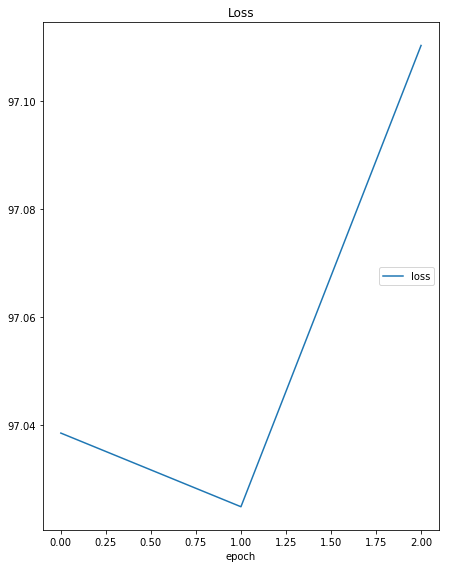

Loss
	loss             	 (min:   97.025, max:   97.110, cur:   97.110)
summary nr: 2
batch nr 0, loss: 91.87505340576172
batch nr 10, loss: 100.27318572998047
batch nr 20, loss: 94.74830627441406
batch nr 30, loss: 96.37623596191406
batch nr 40, loss: 102.85482788085938
batch nr 50, loss: 100.20188903808594
batch nr 60, loss: 98.98729705810547
batch nr 70, loss: 92.27133178710938


In [ ]:
## training loop with adam


checkpoint_path=f"artefacts/ae_v3_checkpoint_family_{INSTRUMENT_FAMILY}"
try:
    print("loading checkpoint")
    ae.load_weights(checkpoint_path)
except:
    print("couldn't load checkpoint")
    pass
e=0

while True:
  batch_counter=0
  epoch_loss=0   
  for batch in batched_dist_trn_dataset:
        it_loss=distributed_train_step(batch)
        epoch_loss+=it_loss
        if batch_counter % 10==0:
            print(f"batch nr {batch_counter}, loss: {it_loss.numpy()}")

        batch_counter+=1
  

  plotlosses.update({'loss': epoch_loss/batch_counter,})

  plotlosses.send()

  print(f"summary nr: {e}")


  #play(tf.reshape(output["audio"],(-1)))
  #play(tf.reshape(output['audio_synth'],(-1)))
  #play(tf.reshape(output['add']["signal"],(-1))) 
    
  #plt.plot(output["ir"][0])
  #plt.show()
    
  ae.save_weights(checkpoint_path)

  e+=1




In [ ]:
play(tf.reshape(batch["audio"],(-1)))
play(tf.reshape(output['add']['signal'],(-1))) 
play(tf.reshape(output['ir'],(-1))) 
play(tf.reshape(output['audio_synth'],(-1))) 

In [ ]:
import pydash

## validation 

val_dataset=list(val_dataset)

VAL_LR=5e-3

# order by velocity
val_dataset=pydash.collections.sort_by(val_dataset,lambda x: x["velocity"].numpy())

#order by pitch
val_dataset=pydash.collections.sort_by(val_dataset,lambda x: x["pitch"].numpy())

# group by instrument id
val_dataset_by_instrument=pydash.collections.group_by(list(val_dataset),lambda x: str(x["instrument"].numpy())+" "+str(x["velocity"].numpy()))

fit_iterations=100

def rf2cf(row_form):
    return {k:[s[k] for s in row_form] for k in row_form[0].keys()}
    
DEMO_NOTE_SAMPLES=int(0.2*SAMPLE_RATE)

for instrument_set in val_dataset_by_instrument.values():    

    val_optimizer = tf.keras.optimizers.Adam(learning_rate=VAL_LR)

    # fit an embedding to highest and lowest note
    
    #fit_data=[instrument_set[int(len(instrument_set)/2)]]
    
    fit_data=[instrument_set[0],instrument_set[int(len(instrument_set)/2)],instrument_set[-1]]
    
    N_FIT_SAMPLES=len(fit_data)
    
    #convert to column form
    fit_data = rf2cf(fit_data)
        
    fit_batch= next(iter(tf.data.Dataset.from_tensor_slices(fit_data).batch(N_FIT_SAMPLES)))
    
    fit_z=tf.Variable(tf.random.normal([1,INSTRUMENT_EMBEDDING_SIZE]))
    fit_ir=tf.Variable(tf.concat([tf.zeros([1,1]),tf.zeros([1,IR_SIZE-1])],axis=-1))
    
    for i in range(fit_iterations):
     
        with tf.GradientTape() as tape:
          fit_batch["z"]=tf.tile(tf.tanh(fit_z),[N_FIT_SAMPLES,1])
          fit_batch["ir"]=tf.tile(tf.tanh(fit_ir),[N_FIT_SAMPLES,1])
            
          output=ae(fit_batch,training=False)

          loss_value=spectral_loss(fit_batch["audio"],output['audio_synth'])

          gradients = tape.gradient(loss_value, [fit_z,fit_ir])
          gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
            
          print(loss_value)
        
        val_optimizer.apply_gradients(zip(gradients, [fit_z,fit_ir]))
        
    print(loss_value)
           
    play(tf.reshape(fit_batch["audio"],(-1)))
    play(tf.reshape(output['audio_synth'],(-1)))
    play(tf.reshape(output['add']["signal"],(-1)))
    play(tf.reshape(fit_ir,(-1)))
        
    N_SCALE_SAMPLES=len(instrument_set)
        
    scale_data = rf2cf(instrument_set) 
    scale_batch= next(iter(tf.data.Dataset.from_tensor_slices(scale_data).batch(N_SCALE_SAMPLES)))
    
    play(tf.reshape(scale_batch["audio"][:,:DEMO_NOTE_SAMPLES],(-1)))
    
    scale_batch["z"] = tf.tile(tf.tanh(fit_z),[N_SCALE_SAMPLES,1])
    scale_batch["ir"] = tf.tile(fit_ir,[N_SCALE_SAMPLES,1])
        
    scale_batch_output=ae(scale_batch,training=False)
    
    play(tf.reshape(scale_batch_output['audio_synth'][:,:DEMO_NOTE_SAMPLES],(-1)))
        

In [ ]:
# sgd training loop

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

checkpoint_path=f"artefacts/ae_v2_checkpoint_family_{INSTRUMENT_FAMILY}"
try:
    print("loading checkpoint")
    ae.load_weights(checkpoint_path)
except:
    print("couldn't load checkpoint")
    pass
e=0


#tf.debugging.experimental.enable_dump_debug_info("logdir", tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

while True:
  batch_counter=0
  epoch_loss=0   
  for batch in batched_trn_dataset:
    a = time.time()

    batch_z=[]
    batch_ir=[]

    # ptr
    for sample_index in range(batch["instrument"].shape[0]):
      instrument_id=batch["instrument"][sample_index].numpy()
      if instrument_id not in instrument_data:
        instrument_data[instrument_id]={}
        instrument_data[instrument_id]["z"]=tf.random.normal([INSTRUMENT_EMBEDDING_SIZE]).numpy()
        instrument_data[instrument_id]["ir"]=tf.random.normal([IR_SIZE],mean=0,stddev=1e-6).numpy()

      batch_z.append(instrument_data[instrument_id]["z"])
      batch_ir.append(instrument_data[instrument_id]["ir"])   

    with tf.GradientTape() as tape:

      batch_z_tf = tf.Variable(tf.stack(batch_z))
      batch_ir_tf = tf.Variable(tf.stack(batch_ir)) 

      batch["z"]=tf.tanh(batch_z_tf)
      batch["ir"]=tf.tanh(batch_ir_tf)

      output=ae(batch,training=False)

      loss_value=spectral_loss(batch["audio"],output['audio_synth'])

      gradients = tape.gradient(loss_value, [batch_z_tf,batch_ir_tf,*ae.trainable_variables])
      gradients, _ = tf.clip_by_global_norm(gradients, 5.0)

      epoch_loss+=loss_value.numpy()

    optimizer.apply_gradients(zip(gradients, [batch_z_tf,batch_ir_tf,*ae.trainable_variables]))

    for sample_index in range(batch["instrument"].shape[0]):
      # TODO: average instrument embeddings per instrument
      instrument_data[instrument_id]["z"]=batch_z_tf[sample_index].numpy()
      instrument_data[instrument_id]["ir"]=batch_ir_tf[sample_index].numpy()

    #print(f"batch took {time.time()-a} s")
        
    batch_counter+=1
    
  plotlosses.update({
    'loss': epoch_loss/batch_counter,
  })

  plotlosses.send()

  print(f"summary nr: {e}")

  print(loss_value)
  play(tf.reshape(batch["audio"],(-1)))
  play(tf.reshape(output['audio_synth'],(-1)))
    
  plt.plot(batch["ir"][0])

  ae.save_weights(checkpoint_path)

  e+=1




# 